Project 6: Fake Product Review Detection

Online product reviews play a major role in influencing customer decisions. However, many platforms are affected by fake or deceptive reviews written to artificially promote or demote products. These misleading reviews can harm customers as well as businesses.

In [14]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

We use a lightweight fake review dataset suitable for machine learning experiments. <br>
Dataset columns: <br>
• review - Textual customer review <br>
• label  - 1 = Fake Review, 0 = Genuine Review <br>
This dataset is intentionally small to ensure fast execution and avoid memory issues in Google Colab.


In [15]:
from google.colab import files
uploaded = files.upload()

Saving Productreviews.csv to Productreviews (1).csv


In [16]:
df = pd.read_csv(list(uploaded.keys())[0])
df.head()

,id,asins,brand,categories,colors,dateAdded,dateUpdated,dimension,ean,keys,...,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sizes,upc,weight
0,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I initially had trouble deciding between the p...,"Paperwhite voyage, no regrets!",NaN,NaN,Cristina M,NaN,NaN,205 grams
1,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,Allow me to preface this with a little history...,One Simply Could Not Ask For More,NaN,NaN,Ricky,NaN,NaN,205 grams
2,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,4.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I am enjoying it so far. Great for reading. Ha...,Great for those that just want an e-reader,NaN,NaN,Tedd Gardiner,NaN,NaN,205 grams
3,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I bought one of the first Paperwhites and have...,Love / Hate relationship,NaN,NaN,Dougal,NaN,NaN,205 grams
4,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I have to say upfront - I don't like coroporat...,I LOVE IT,NaN,NaN,Miljan David Tanic,NaN,NaN,205 grams


Before building a model, it is important to ensure: <br>
• No missing values exist <br>
• Columns are correctly named <br>
• Labels are in numerical format <br>
This step prevents runtime errors and ensures smooth training.

In [24]:
df = pd.read_csv(list(uploaded.keys())[0])
print("Original columns after re-loading:", df.columns)
df_processed = df[['reviews.text', 'reviews.rating']].copy()
print("\nMissing values in selected columns before dropping:\n", df_processed.isnull().sum())
df_processed.dropna(subset=['reviews.text', 'reviews.rating'], inplace=True)
df_processed = df_processed.rename(columns={
    'reviews.text': 'review',
    'reviews.rating': 'label'
})
df_processed['label'] = df_processed['label'].apply(lambda x: 1 if x <= 2 else 0).astype(int)
df = df_processed
print("\nDataFrame head after processing:")
print(df.head())
print("\nDataFrame shape after processing:", df.shape)
print("\nLabel distribution (0=Genuine, 1=Fake):")
print(df['label'].value_counts())

Original columns after re-loading: Index(['id', 'asins', 'brand', 'categories', 'colors', 'dateAdded',
       'dateUpdated', 'dimension', 'ean', 'keys', 'manufacturer',
       'manufacturerNumber', 'name', 'prices', 'reviews.date',
       'reviews.doRecommend', 'reviews.numHelpful', 'reviews.rating',
       'reviews.sourceURLs', 'reviews.text', 'reviews.title',
       'reviews.userCity', 'reviews.userProvince', 'reviews.username', 'sizes',
       'upc', 'weight'],
      dtype='object')

Missing values in selected columns before dropping:
 reviews.text        0
reviews.rating    420
dtype: int64

DataFrame head after processing:
                                              review  label
0  I initially had trouble deciding between the p...      0
1  Allow me to preface this with a little history...      0
2  I am enjoying it so far. Great for reading. Ha...      0
3  I bought one of the first Paperwhites and have...      0
4  I have to say upfront - I don't like coroporat...      0

Dat

Raw text cannot be used directly by machine learning models. <br>
I cleaned the reviews by: <br>
• Converting text to lowercase <br>
• Removing punctuation and numbers <br>
• Removing extra spaces <br>
This improves feature quality and model performance.

In [25]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()
df['cleaned_review'] = df['review'].apply(clean_text)
df[['review', 'cleaned_review']].head()

,review,cleaned_review
0,I initially had trouble deciding between the p...,i initially had trouble deciding between the p...
1,Allow me to preface this with a little history...,allow me to preface this with a little history...
2,I am enjoying it so far. Great for reading. Ha...,i am enjoying it so far great for reading had ...
3,I bought one of the first Paperwhites and have...,i bought one of the first paperwhites and have...
4,I have to say upfront - I don't like coroporat...,i have to say upfront i dont like coroporate h...


TF-IDF (Term Frequency–Inverse Document Frequency) converts text into numerical vectors. <br>
It assigns: <br>
• Higher weight to important words <br>
• Lower weight to commonly occurring words <br>
This helps the model focus on meaningful terms.

In [26]:
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2)
)
X = tfidf.fit_transform(df['cleaned_review'])
y = df['label']
print("TF-IDF Matrix Shape:", X.shape)

TF-IDF Matrix Shape: (1177, 5000)


We divide the dataset into: <br>
• Training set (80%) <br>
• Testing set (20%) <br>
This helps evaluate how well the model generalizes to unseen data.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


I used **Logistic Regression**, a strong baseline model for text classification. <br>
It works well with TF-IDF features and is efficient for large text datasets.

In [33]:
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

To evaluate performance: <br>
• Accuracy <br>
• Confusion Matrix <br>
• Precision, Recall, and F1-score <br>


In [34]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)

Model Accuracy: 0.923728813559322


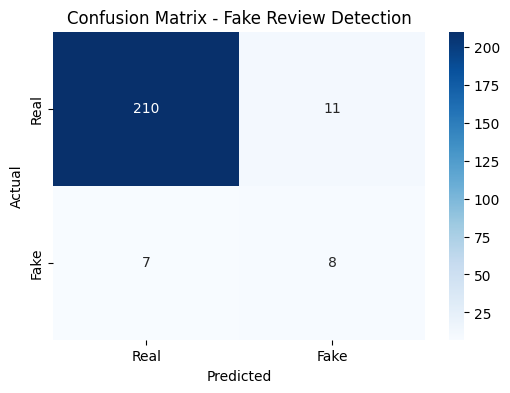

In [35]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'],
            yticklabels=['Real', 'Fake'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Fake Review Detection")
plt.show()

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       221
           1       0.42      0.53      0.47        15

    accuracy                           0.92       236
   macro avg       0.69      0.74      0.71       236
weighted avg       0.93      0.92      0.93       236



This project demonstrates how machine learning can help improve trust and reliability in online platforms.